In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import scanpy as sc
import anndata as ad
import snapatac2 as snap
import muon.atac as ma
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from umap import UMAP
import seaborn as sns
from plotnine import *
import pyranges as pr
import os
import warnings
import requests
from tqdm import tqdm
plt.rcdefaults()
import pysam as ps

from sklearn.metrics.pairwise import cosine_similarity
import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import squareform
from scipy.stats import mannwhitneyu, false_discovery_control, ttest_ind

import sys
sys.path.append('/scratch/eli')
from perturbseq import *
from sparsepca import *

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['pdf.fonttype'] = 42

### 2a) Differential genes and peaks across perturbations

In [4]:
# output from fig 1e

pop = CellPopulation.from_hdf("../intermediate_files/gex_norm_regressed.hdf5")
pop.genes['gene_name'] = pop.genes.index
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    meanpop = pop.average("guide_identity")

Loading matrix...
Loading metadata...
Done in 3.191627264022827s.
Generating summary statistics...
Done.
Computing average expression matrices...
Computing clusters...
Generating summary statistics...
Done.


In [ ]:
# genes by KS test from perturbseq

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ks, p, adj_p = ks_de(
        pop, key = "guide_identity", 
        control_cells = "guide_identity == 'NTC'", 
        n_jobs = 24,
    )

adj_p = adj_p.drop("NTC", axis = 1)
degs_by_guide = {}
for col in adj_p.columns:
    degs_by_guide[col] = adj_p.query(f"{col} < 0.1").index
df_degs = pd.DataFrame()
df_degs['guide_identity'] = [k for k in degs_by_guide.keys()]
df_degs['DEGs'] = [v.tolist() for v in degs_by_guide.values()]
df_degs.explode("DEGs").to_csv("intermediate_files/degs.csv", index=None)

groupby: index in @key_barcodes (key = guide_identity)


In [ ]:
# peaks by mann-whitney on atac counts

atac = snap.read("intermediate_files/Lane1_040_preprocessed_atac.h5ad", backed = None)
atac = atac[atac.obs.index.isin(pop.cells.index)]
atac = atac[:,atac.var.selected].copy()
atac.obs = atac.obs.join(pop.cells.guide_identity)

snap.tl.macs3(atac, groupby="guide_identity")
atac.write("intermediate_files/atac_singlets_macs3_peaks.h5ad")

2024-06-14 11:43:33 - INFO - Exporting fragments...
2024-06-14 11:44:15 - INFO - Calling peaks...
100%|██████████| 14/14 [04:31<00:00, 19.37s/it]
... storing 'guide_identity' as categorical


In [ ]:
atac = snap.read("intermediate_files/atac_singlets_macs3_peaks.h5ad", backed = None)
peaks = snap.tl.merge_peaks(atac.uns['macs3'], snap.genome.hg38)
mtx = snap.pp.make_peak_matrix(atac, use_rep=peaks['Peaks'], counting_strategy='paired-insertion')

guides = mtx.obs.guide_identity.unique().tolist()
guides.remove("NTC")
dfs = []
for guide_target in tqdm(guides):

    # first part follows SnapATAC documentation, then we do a different statistical test
    
    selected_peaks = np.logical_or(peaks[guide_target].to_numpy(), peaks['NTC'].to_numpy())
    peak_names = peaks.to_pandas().query(f"{guide_target} or NTC").Peaks

    target_mtx = mtx[mtx.obs.guide_identity == guide_target, selected_peaks].X.toarray()
    ctrl_mtx = mtx[mtx.obs.guide_identity == "NTC", selected_peaks].X.toarray()

    ps = mannwhitneyu(target_mtx, ctrl_mtx, axis = 0).pvalue
    lfcs = np.log2(np.divide(1e-3 + target_mtx.mean(axis=0), 1e-3 + ctrl_mtx.mean(axis = 0)))
    adj_ps = false_discovery_control(ps)

    df_peaks = pd.DataFrame({'feature': peak_names, 'l2fc': lfcs, 'p': ps, 'q': adj_ps, 'guide_target': guide_target})
    dfs.append(df_peaks)

df_mwu = pd.concat(dfs, axis = 0)
df_mwu.to_csv("intermediate_files/all_diff_peaks_mwu.csv", index = None)

100%|██████████| 13/13 [03:56<00:00, 18.22s/it]


In [5]:
degs = pd.read_csv("../intermediate_files/degs.csv").guide_identity.value_counts().to_frame("degs")
daps = pd.read_csv("../intermediate_files/all_diff_peaks_mwu.csv").query("q < 0.1").guide_target.value_counts().to_frame("daps")
cells = pop.cells.guide_identity.value_counts().to_frame("cells")

In [6]:
df_diff = pd.concat([degs, daps, cells], axis = 1).drop("NTC", axis = 0)
df_diff.columns = ['degs', 'daps', 'cells']
df_diff = df_diff.reset_index().rename({"index": "guide_identity"}, axis = 1)
complex_dict = dict(zip(['SMARCC1', 'EZH2', 'SUZ12', 'ARID1A', 'EP400', 'SMARCA4', 'SMARCE1', 'YY1', 'ACTL6A', 'SMARCB1', 'SMARCC2', 'DPF2', 'DMAP1'],['BAF', 'Poly', 'Poly', 'BAF', 'NuA4', 'BAF', 'BAF', 'Poly', 'NuA4', 'BAF', 'BAF', 'BAF', 'NuA4']))
df_diff['complex'] = df_diff.guide_identity.map(complex_dict)
colors_dict = {'NuA4': '#3e356b', 'BAF':'#357ba1', 'Poly': '#4bc2ad'}
df_diff['color'] = df_diff.complex.map(colors_dict)

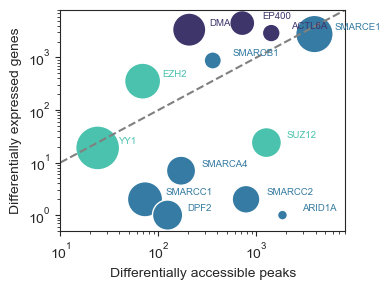

In [ ]:
with sns.axes_style("ticks"):

    plt.figure(figsize = (4,3))
    sns.scatterplot(data = df_diff, x = 'daps', y = 'degs', size = 'cells', hue = 'complex', palette='mako', sizes = (50,1000), legend = False)
    plt.xscale('log')
    plt.yscale('log')
    plt.axline([1,1],[2,2], linestyle = 'dashed', color = 'grey')
    plt.xlim((1e1,8e3))
    plt.ylim((0.5,8e3))
    plt.xlabel("Differentially accessible peaks")
    plt.ylabel("Differentially expressed genes")

    for idx, row in df_diff.iterrows():
        plt.text(x = 1.6*row.daps, y = 1.2*row.degs, s = row.guide_identity, c = row.color, size = 'x-small')
    plt.tight_layout()
    plt.savefig("outs/figs_v1/fig2a_degs_daps.pdf")
    plt.show()

### 2b) Phenotype correlation of GEX only

In [3]:
pca = PCAReducer(n_components=10)
pca_rep = pop.fit_transform(pca)

In [4]:
df_pca = pca_rep.join(pop.cells.guide_identity).groupby("guide_identity").mean()
distance = 1 - df_pca.drop("NTC", axis = 0).T.corr()
link = hc.linkage(squareform(distance), method = 'ward')

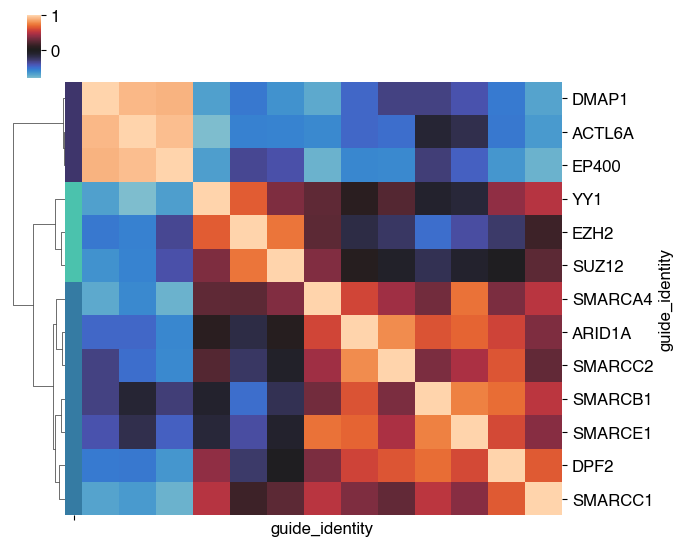

In [5]:
plt.rcParams['axes.unicode_minus'] = False
colors = pd.Series(['#3e356b', '#357ba3', '#3e356b', '#357ba3', '#3e356b','#4bc2ad','#357ba3', '#357ba3', '#357ba3','#357ba3','#357ba3','#4bc2ad','#4bc2ad'], index = df_pca.drop("NTC",axis=0).index)
cg = sns.clustermap(df_pca.drop("NTC", axis = 0).T.corr(), cmap = 'icefire', metric = 'correlation', center = 0, row_linkage = link, col_linkage = link,dendrogram_ratio=0.1, figsize = (7,6.3), cbar_kws={'shrink':0.5}, row_colors = colors)
cg.ax_col_dendrogram.set_visible(False)
cg.ax_heatmap.set_xticks([])
cbar = cg.cax.set_position([0.05, 0.9, 0.02, 0.1])

plt.xlabel("")
plt.savefig("outs/figs_v1/fig2b_gex_correlation.pdf")
plt.show()

### 2c) Phenotype correlation of ATAC only

In [ ]:
atac = snap.read("intermediate_files/Lane1_040_preprocessed_atac.h5ad", backed = None)
atac = atac[atac.obs.index.isin(pop.cells.index)]
atac = atac[:,atac.var.selected].copy()
atac.obs = atac.obs.join(pop.cells.guide_identity)

In [ ]:
snap.tl.spectral(atac, n_comps = 11)
df = pd.DataFrame(atac.obsm['X_spectral'], index = atac.obs.index).join(pop.cells.guide_identity)

In [ ]:
# first embedding component correlates strongly with sequencing depth (n_fragment) and is removed

df_first_comp_removed = df.iloc[:,1:]
df_first_comp_removed = df_first_comp_removed.groupby("guide_identity").mean().drop("NTC", axis = 0)

distance = 1 - cosine_similarity(df_first_comp_removed)
distance[distance < 1e-15] = 0
link = hc.linkage(squareform(distance), method = 'ward', optimal_ordering=True)

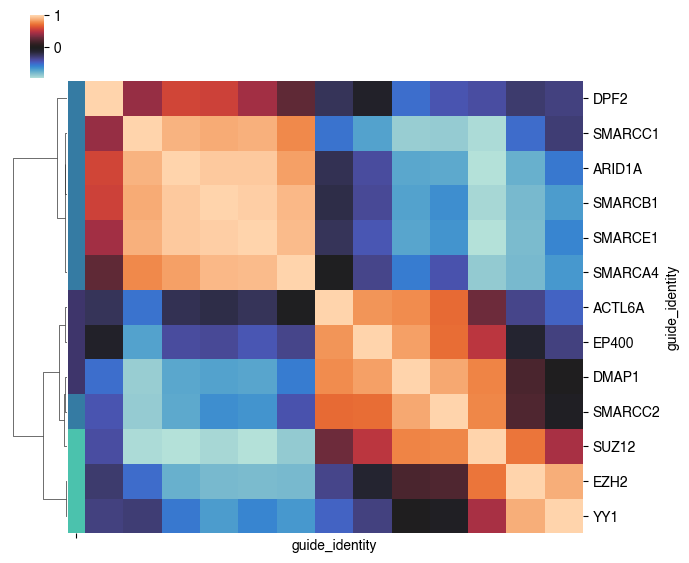

In [ ]:
colors = pd.Series(['#3e356b', '#357ba3', '#3e356b', '#357ba3', '#3e356b','#4bc2ad','#357ba3', '#357ba3', '#357ba3','#357ba3','#357ba3','#4bc2ad','#4bc2ad'], index = df_first_comp_removed.index)
cg = sns.clustermap(df_first_comp_removed.T.corr(lambda x,y: cosine_similarity(x.reshape(1,-1), y.reshape(1,-1))), cmap = 'icefire', center = 0, row_linkage = link, col_linkage = link, row_colors = colors, dendrogram_ratio=0.1, figsize = (7,6.3), cbar_kws={'shrink':0.5})
cg.ax_col_dendrogram.set_visible(False)
cg.ax_heatmap.set_xticks([])
cg.cax.set_position([0.05, 0.9, 0.02, 0.1])
plt.savefig("outs/figs_v1/fig2c_atac_correlation.pdf")

### 2d) Sparse PCA to find gene/peak programs

In [2]:
atac = snap.read("../intermediate_files/atac_singlets_macs3_peaks.h5ad", backed = None)
peaks = snap.tl.merge_peaks(atac.uns['macs3'], snap.genome.hg38)
mtx = snap.pp.make_peak_matrix(atac, use_rep=peaks['Peaks'], counting_strategy='paired-insertion')

In [3]:
mtx.var["Chromosome"] = mtx.var.index.map(lambda s: s.split(":")[0])
mtx.var["Start"] = mtx.var.index.map(lambda s: int(s.split(":")[1].split("-")[0]))
mtx.var["End"] = mtx.var.index.map(lambda s: int(s.split(":")[1].split("-")[1]))

In [4]:
gr = pr.PyRanges(mtx.var)

gtf = pr.read_gtf('/fscratch/eli/genomes/refdata-gex-GRCh38-2020-A/genes/genes.gtf')[["Chromosome", "Feature", "Start", "End", "gene_id", "gene_type", "gene_name"]]
gtf = gtf[gtf.Feature == 'gene']
df_nearest_gene = gr.nearest(gtf)
df_nearest_gene = df_nearest_gene.df[["Chromosome", "Start", "End", "gene_name", "Distance"]]
df_nearest_gene['peak_id'] = df_nearest_gene.apply(lambda row: f"{row.Chromosome}:{row.Start}-{row.End}", axis=1)
df_nearest_gene = df_nearest_gene.set_index("peak_id").drop(["Chromosome", "Start", "End"], axis = 1)

mtx.var = mtx.var.join(df_nearest_gene)

snap.pp.select_features(mtx, filter_lower_quantile=0.25, inplace = True)

/home/metznere/.conda/envs/scenv/lib/python3.11/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/metznere/.conda/envs/scenv/lib/python3.11/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/metznere/.conda/envs/scenv/lib/python3.11/site-packages/pyranges/methods/init.py:160: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
join: Strand data 

In [5]:
df_ntc = mtx[mtx.obs.guide_identity == 'NTC',(mtx.var.selected) & (mtx.var.Distance < 5e4)].to_df()
df_mtx = mtx[mtx.obs.guide_identity != 'NTC',(mtx.var.selected) & (mtx.var.Distance < 5e4)].to_df()

ctrl_mean, ctrl_std = df_ntc.mean(axis = 0), df_ntc.std(axis = 0)
df_mtx_normalized = df_mtx.sub(ctrl_mean).div(ctrl_std)
pseudo_mtx_normalized = df_mtx_normalized.join(mtx.obs.guide_identity, how = 'inner').groupby("guide_identity").mean().drop("NTC", axis = 0)

/tmp/ipykernel_283613/1153692447.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [6]:
pop = CellPopulation.from_hdf("../intermediate_files/gex_norm_regressed.hdf5")
pop.genes['gene_name'] = pop.genes.index
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    meanpop = pop.average("guide_identity")

Loading matrix...
Loading metadata...
Done in 3.6309661865234375s.
Generating summary statistics...
Done.
Computing average expression matrices...
Computing clusters...
Generating summary statistics...
Done.


In [7]:
df_normalized = pd.concat([pseudo_mtx_normalized, meanpop.matrix.drop("NTC", axis = 0)], axis = 1)
degs = pd.read_csv("../intermediate_files/degs.csv", index_col = 0).DEGs.unique()
daps = pd.read_csv("../intermediate_files/all_diff_peaks_mwu.csv", index_col = 0).query("q < 0.1").index.unique()
features = degs.tolist() + daps.tolist()
df_normalized_diff = df_normalized.filter(items = features)

In [8]:
print(df_normalized_diff.columns.str.startswith("chr").sum())
print(len(df_normalized_diff.columns) - df_normalized_diff.columns.str.startswith("chr").sum())

5060
7885


In [9]:
sparsepca = NonNegativeSparsePCA(n_components=8, alpha = 0.25, method = 'cd', max_iter = 1000, verbose = 0, n_jobs = 24)
programs = sparsepca.fit_transform(df_normalized_diff)

In [10]:
df_normalized_programs_diff = pd.DataFrame(programs, index = df_normalized_diff.index)
df_normalized_programs_diff.loc['nonzero',:] = df_normalized_programs_diff.apply(lambda row: (row != 0).sum(), axis = 0)
df_normalized_programs_diff = df_normalized_programs_diff.T.query("nonzero > 0").T.drop("nonzero", axis = 0)
df_normalized_programs_diff.to_csv("supplementary_outs/TableS4_perturbation_weights.csv")
df_normalized_programs_diff

,0,1,2,3,4,5,6,7
ACTL6A,0.247742,-3.150884,-0.997365,5.806353,-1.275989,0.498086,2.596307,0.720762
ARID1A,-0.634837,1.129346,6.962381,-0.728048,-0.878478,0.116156,-0.484143,-1.147800
DMAP1,0.903191,-3.127112,-0.602648,0.482240,-0.033923,-0.740691,3.354926,4.210441
DPF2,-0.551215,0.869412,-0.485664,-0.899567,-0.227258,-0.460670,-0.659451,-0.595030
EP400,4.982220,-3.174959,-0.506818,0.236942,-0.407015,-0.871676,1.974127,1.647803
EZH2,-0.049972,0.511354,-0.692599,-0.654185,1.511815,-1.434027,-1.736233,0.446617
SMARCA4,-0.755450,1.246192,-0.898153,-0.629531,-0.743977,0.090803,-0.587696,-0.954528
SMARCB1,-1.697127,1.249478,-0.907435,-0.629642,-2.100607,3.830166,0.129740,-2.348166
SMARCC1,-0.482208,0.766171,-0.334994,-0.813287,-0.088960,-0.609510,-0.636648,-0.491124
SMARCC2,-0.148018,0.736623,-0.159060,-0.826386,0.346438,-0.977969,-0.714700,-0.137684


In [11]:
peak_dict = dict(zip(mtx.var.index, mtx.var.gene_name))
distance_dict = dict(zip(mtx.var.index, mtx.var.Distance))
components_diff = pd.DataFrame(sparsepca.components_, columns=df_normalized_diff.columns).reset_index().rename({'index':'program_id'}, axis = 1)
programs_diff = components_diff.melt(id_vars = 'program_id', var_name = 'feature', value_name = 'weight').query("weight != 0").sort_values(["program_id", "weight"], ascending = False)
programs_diff['feature_type'] = programs_diff.feature.map(lambda s: "peak" if s.startswith("chr") else "gene")
programs_diff['feature_peak_associated'] = programs_diff.feature.map(lambda f: peak_dict.get(f, f))
programs_diff['gene_distance'] = programs_diff.feature.map(lambda f: distance_dict.get(f, np.nan))

In [12]:
genes = programs_diff.groupby("program_id").feature_type.value_counts().to_frame("count").reset_index().query("feature_type == 'gene'")['count']
peaks = programs_diff.groupby("program_id").feature_type.value_counts().to_frame("count").reset_index().query("feature_type == 'peak'")['count']
df_counts = pd.DataFrame(index = df_normalized_programs_diff.index, columns = df_normalized_programs_diff.columns).applymap(lambda x: float(x))
df_counts.loc['overlap',:] = pd.DataFrame({
    'program_id': [i for i in programs_diff.program_id.unique()], 
    'overlap': [len(np.intersect1d(programs_diff.query(f"program_id == {i} and feature_type == 'gene'").feature_peak_associated, programs_diff.query(f"program_id == {i} and feature_type == 'peak'").feature_peak_associated)) for i in programs_diff.program_id.unique()]
}).set_index("program_id").sort_index().overlap.tolist()
df_counts.loc['genes',:] = genes.tolist()
df_counts.loc['peaks',:] = peaks.tolist()

/tmp/ipykernel_283613/3180768626.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.


In [19]:
distance = 1 - df_normalized_programs_diff.T.corr()
link = hc.linkage(squareform(distance), method = 'ward', optimal_ordering=True)

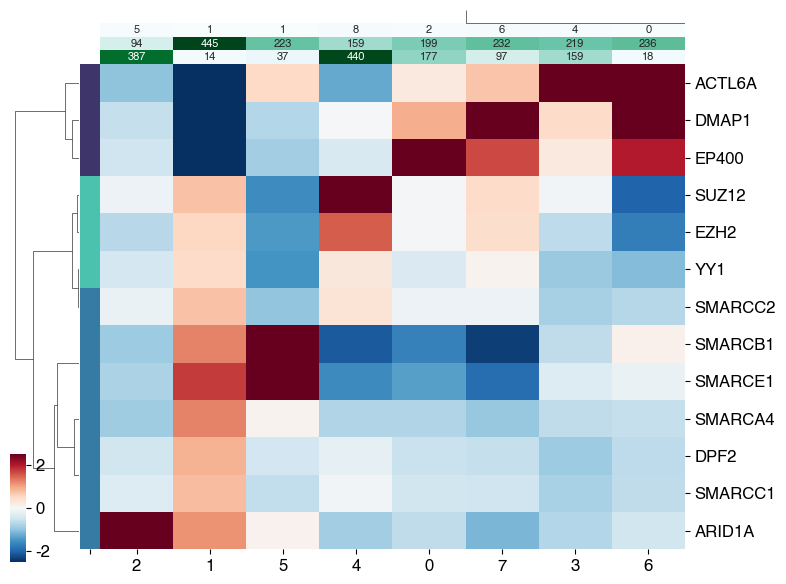

In [20]:
colors = pd.Series(['#3e356b', '#357ba3', '#3e356b', '#357ba3', '#3e356b','#4bc2ad','#357ba3', '#357ba3', '#357ba3','#357ba3','#357ba3','#4bc2ad','#4bc2ad'], index = df_normalized_programs_diff.index)
cg = sns.clustermap(df_normalized_programs_diff, cmap = 'RdBu_r', metric = 'correlation', center = 0, vmin = -2.5, vmax = 2.5, figsize = (8,6), cbar_pos=(0.02, 0.05, 0.02, 0.18), row_linkage = link, row_colors = colors, dendrogram_ratio=0.1)
heatmap = df_counts.dropna().iloc[:,cg.dendrogram_col.reordered_ind]
blank_rows = pd.DataFrame(np.nan, index=range(1), columns=heatmap.columns)
df_heatmap = pd.concat([blank_rows, heatmap], ignore_index=True)
sns.heatmap(df_heatmap, ax = cg.ax_col_dendrogram, cmap = 'BuGn', cbar = False, annot = True, fmt = '.0f', annot_kws = {'size': 8}, xticklabels = False, yticklabels = True)
# plt.savefig("outs/figs_v1/fig2d_programs.pdf")
plt.show()

In [13]:
# annotate TFs and regulatory elements within programs

tfs = pd.read_csv("/data/norman/eli/cut+run/231027/analysis/temp/targeted_tf_promoters.bed", sep = '\t', header = None)
tfs.columns = ["Chromosome", "Start", "End", "gene_name"]
tfs = tfs.gene_name.unique()
programs_diff['is_tf'] = programs_diff.feature_peak_associated.isin(tfs)

program_peaks = pd.DataFrame({'peak_id': programs_diff.query("feature_type == 'peak'").feature.unique()})
program_peaks[['Chromosome', 'pos']] = program_peaks.peak_id.str.split(":", expand = True)
program_peaks[['Start', 'End']] = program_peaks.pos.str.split("-", expand = True)
program_peaks = pr.PyRanges(program_peaks.drop("pos", axis = 1).set_index("peak_id"))

reg_elements = pd.read_csv("../intermediate_files/encodeCcreCombined.bed", sep = '\t', header = None).iloc[:,[0,1,2,12]]
reg_elements.columns = ["Chromosome", "Start", "End", "reg"]
reg_elements = reg_elements.query("reg != 'prom'")

promoters = pd.read_csv("/home/normant1/notebooks/methylation variation/epdNewHuman006_extended_promoter_regions.bed", sep = '\t', header = None).iloc[:,:3]
promoters.columns = ["Chromosome", "Start", "End"]
promoters['reg'] = 'prom'

reg_elements = pr.PyRanges(pd.concat([reg_elements, promoters], axis = 0))

reg_mapped = program_peaks.join(reg_elements, how = 'left').df[['Chromosome', 'Start', 'End', 'reg']]
reg_mapped['reg'] = reg_mapped.reg.map(lambda r: np.nan if r == '-1' else r)
reg_mapped['peak_id'] = reg_mapped.apply(lambda df: df.Chromosome + ":" + str(df.Start) + "-" + str(df.End), axis = 1)
reg_mapped = reg_mapped.drop_duplicates().groupby("peak_id")['reg'].agg(list).to_frame("reg")
reg_dict = dict(zip(reg_mapped.index, reg_mapped.reg))

programs_diff['peak_annotation'] = programs_diff.feature.map(lambda f: reg_dict.get(f, np.nan))
programs_diff.peak_annotation = programs_diff.peak_annotation.astype(str)
programs_diff['edited_peak_annotation'] = programs_diff.peak_annotation.map(lambda a: 'prom' if 'prom' in a else 'enhP' if 'enhP' in a else 'enhD' if 'enhD' in a else 'CTCF' if 'CTCF' in a else 'K4m3' if 'K4m3' in a else np.nan)
programs_diff['edited_peak_annotation'] = programs_diff.apply(lambda df: 'genic_unlabeled' if df.feature_type == 'peak' and df.edited_peak_annotation is np.nan and df.gene_distance == 0 else 'intergenic_unlabeled' if df.feature_type == 'peak' and df.edited_peak_annotation is np.nan else df.edited_peak_annotation, axis = 1)

/home/metznere/.conda/envs/scenv/lib/python3.11/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


/home/metznere/.conda/envs/scenv/lib/python3.11/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [21]:
programs_diff.fillna("").drop("peak_annotation", axis = 1).to_csv("supplementary_outs/TableS4_feature_weights.csv", index = None)

In [19]:
def plot_program_enrichment(program_id, programs_diff, filter_features = None, plot = True, savefig = None, figsize = (14,4)):

    genes = programs_diff.query(f"program_id == {program_id} and feature_type == 'gene'").feature
    df_genes = meanpop.matrix.loc[:,genes].drop("NTC", axis = 0)
    df_genes.columns = df_genes.columns.map(lambda col: col + "_g")

    peaks = programs_diff.query(f"program_id == {program_id} and feature_type == 'peak'").drop_duplicates("feature_peak_associated", keep = 'first').feature # only keep a single peak from each gene for visualization, can be turned off for exploration
    allpeaks = programs_diff.query(f"program_id == {program_id} and feature_type == 'peak'").feature
    df_peaks = df_normalized_diff[peaks].copy()
    df_peaks.columns = df_peaks.columns.map(lambda s: peak_dict.get(s, np.nan)).map(lambda col: col + "_p")
    df_allpeaks = df_normalized_diff[allpeaks].copy()

    score = np.dot(pd.concat([df_genes, df_allpeaks], axis = 1), programs_diff.query(f"program_id == {program_id}").weight)
    df_score = pd.DataFrame(score, index = df_allpeaks.index, columns = ['score'])

    df = pd.concat([df_genes, df_peaks, df_score], axis = 1).sort_values("score", ascending = False)
    if filter_features is not None:
        cols = [col for col in df.columns if any([f in col for f in filter_features]) or col == 'score']
        df = df[cols]
    
    df_genes = df.copy()
    df_genes[df.filter(like = "_p").columns.tolist() + df.filter(like = "score").columns.tolist()] = np.nan
    df_genes.rename(columns = lambda col: col.split("_")[0] if "_" in col else col, inplace = True)

    df_peaks = df.copy()
    df_peaks[df.filter(like = '_g').columns.tolist() + df.filter(like = "score").columns.tolist()] = np.nan
    df_peaks.columns = df_peaks.columns.map(lambda col: col.split("_")[0] if "_" in col else col)

    df_score = df.copy()
    df_score.iloc[:,:-1] = np.nan
    df_score.columns = df_score.columns.map(lambda col: col.split("_")[0] if "_" in col else col)
    
    if plot:

        plt.figure(figsize = figsize)
        sns.heatmap(df_genes.drop("score", axis = 1), cmap = 'mako', cbar = False)
        sns.heatmap(df_peaks.drop("score", axis = 1), cmap = 'rocket', cbar = False)
        # sns.heatmap(df_score, cmap = 'Spectral_r', cbar = False, center = 0)
        plt.tight_layout()
        if savefig is not None:
            plt.savefig(savefig)
        plt.show()

    return df_genes, df_peaks

### 2e) Zoom in on ARID1A program

In [7]:
# revised to highlight retinal neuron markers and NEUROD4

retina_genes = pd.read_excel("/scratch/eli/retina_markers.xlsx", sheet_name=None)
for ct, df in retina_genes.items():
    df['celltype'] = ct
markers = pd.concat(retina_genes.values())
markers_filtered = markers.query("scores > 0 and pvals_adj < 0.1 and celltype.isin(['PRPC','NRPC','Rod','Cone'])")
program_features = pd.read_csv("../supplementary_outs/TableS4_feature_weights.csv").query("program_id == 2 and feature_peak_associated.isin(@markers_filtered.names)")
highlight_genes = list(set([p for p in program_features.feature_peak_associated if p.find(".") == -1 and p.find("LINC") == -1])) + ['NEUROD4']

2024-09-28 13:44:15 - INFO - maxp pruned
2024-09-28 13:44:15 - INFO - cmap pruned
2024-09-28 13:44:15 - INFO - post pruned
2024-09-28 13:44:15 - INFO - FFTM dropped
2024-09-28 13:44:15 - INFO - GPOS pruned
2024-09-28 13:44:15 - INFO - GSUB pruned
2024-09-28 13:44:15 - INFO - name pruned
2024-09-28 13:44:15 - INFO - glyf pruned
2024-09-28 13:44:15 - INFO - Added gid0 to subset
2024-09-28 13:44:15 - INFO - Added first four glyphs to subset
2024-09-28 13:44:15 - INFO - Closing glyph list over 'GSUB': 36 glyphs before
2024-09-28 13:44:15 - INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'X', 'Y', 'Z', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'three', 'two', 'uni0008', 'zero']
2024-09-28 13:44:15 - INFO - Glyph IDs:   [0, 1, 2, 3, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 61, 62, 63]
2024-09-28 13

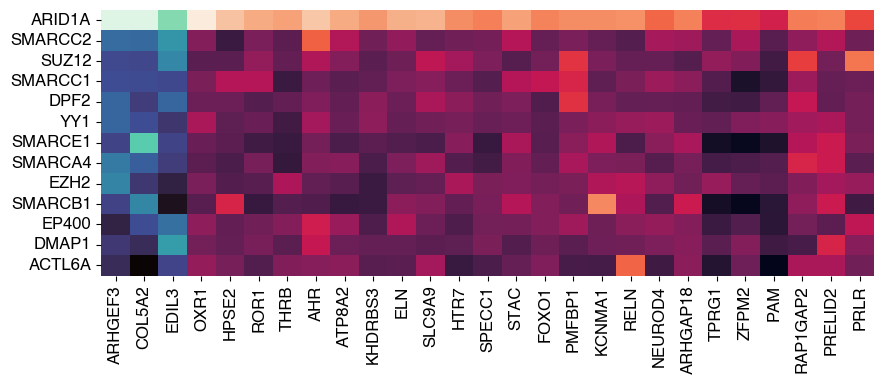

In [65]:
genes, peaks = plot_program_enrichment(2, programs_diff, filter_features = highlight_genes, figsize=(9,4), savefig = 'outs/fig2e_arid_prgm_REVISED.pdf')

2024-09-28 13:44:21 - INFO - maxp pruned
2024-09-28 13:44:21 - INFO - cmap pruned
2024-09-28 13:44:21 - INFO - post pruned
2024-09-28 13:44:21 - INFO - FFTM dropped
2024-09-28 13:44:21 - INFO - GPOS pruned
2024-09-28 13:44:21 - INFO - GSUB pruned
2024-09-28 13:44:21 - INFO - name pruned
2024-09-28 13:44:21 - INFO - glyf pruned
2024-09-28 13:44:21 - INFO - Added gid0 to subset
2024-09-28 13:44:21 - INFO - Added first four glyphs to subset
2024-09-28 13:44:21 - INFO - Closing glyph list over 'GSUB': 46 glyphs before
2024-09-28 13:44:21 - INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'X', 'Z', 'a', 'c', 'd', 'e', 'eight', 'f', 'four', 'i', 'k', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'seven', 't', 'three', 'two', 'u', 'underscore', 'uni0008']
2024-09-28 13:44:21 - INFO - Glyph IDs:   [0, 1, 2, 3, 22, 23, 24, 25, 28, 29, 30, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 55

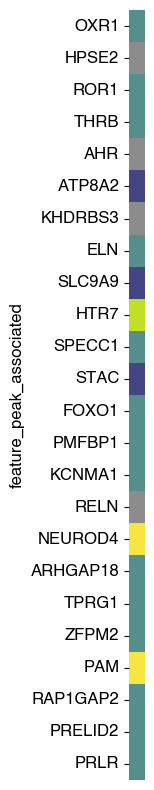

In [66]:
# plot regulatory annotations separately

reg_color_dict = {'enhP':'#86c769', 'enhD':'#558f8c', 'prom':'#f7e642', 'CTCF': '#444684', 'intergenic_unlabeled': '#d7d7d7', 'genic_unlabeled': '#8c8c8c', 'K4m3': '#c0df25'}
reg_map = dict(zip(reg_color_dict.keys(), np.arange(len(reg_color_dict.keys()))))
df_p2_regs = programs_diff.query("program_id == 2 and feature_type == 'peak' and feature_peak_associated.isin(@highlight_genes)").sort_values("weight", ascending = False).drop_duplicates("feature_peak_associated", keep = 'first')[['feature_peak_associated','edited_peak_annotation']]
df_p2_regs['edited_peak_annotation'] = df_p2_regs.edited_peak_annotation.map(reg_map)
df_p2_regs = df_p2_regs.set_index("feature_peak_associated")
df_p2_regs['edited_peak_annotation'] = df_p2_regs.edited_peak_annotation.astype(int)
cmap = ListedColormap([list(reg_color_dict.values())[i] for i in sorted(df_p2_regs.edited_peak_annotation.unique().tolist())])
df_p2_regs['edited_peak_annotation'] = df_p2_regs.edited_peak_annotation.map(lambda i: i - 1 if i == 5 else i)
plt.figure(figsize = (0.2,10))
sns.heatmap(df_p2_regs[['edited_peak_annotation']].astype(int), cmap = cmap, cbar = False, xticklabels = False)
plt.savefig("outs/fig2e_reg_annotations.pdf")

### 2f) NEUROD4 promoter peak

In [ ]:
# promoter of neuro lineage TF

print(programs_diff.query("program_id == 2 and feature_peak_associated == 'NEUROD4'"))
print('NEUROD4' in pop.genes.index)

       program_id                  feature    weight feature_type  \
92502           2  chr12:55019720-55020221  0.006625         peak   

      feature_peak_associated  
92502                 NEUROD4  
False


In [ ]:
arid_bcs = pop.cells.query("guide_identity == 'ARID1A'").index
ntc_bcs = pop.cells.query("guide_identity == 'NTC'").index

In [ ]:
# takes 40 min don't run again

orig_bam = ps.AlignmentFile("/data/norman/eli/T7/202404_SIRLOIN_multiome/Lane1_040/outs/atac_possorted_bam.bam", 'rb')
arid_bam = ps.AlignmentFile("intermediate_files/ARID1A_atac.bam", 'wb', template=orig_bam)
ntc_bam = ps.AlignmentFile("intermediate_files/NTC_atac.bam", 'wb', template=orig_bam)

for read in tqdm(orig_bam, total=orig_bam.mapped):
    cb_tag = read.get_tag("CB") if read.has_tag("CB") else None
    if cb_tag in arid_bcs:
        arid_bam.write(read)
    elif cb_tag in ntc_bcs:
        ntc_bam.write(read)
    else:
        continue

orig_bam.close()
arid_bam.close()
ntc_bam.close()

In [ ]:
# create depth-normalized bw files for visualization

!bamCoverage -b NTC_atac.bam -o NTC_coverage.bw --normalizeUsing RPGC --effectiveGenomeSize 2913022398 --binSize 20 -p 24
!bamCoverage -b ARID1A_atac.bam -o ARID1A_coverage.bw --normalizeUsing RPGC --effectiveGenomeSize 2913022398 --binSize 20 -p 24

In [ ]:
# get cCREs ready for visualization

bed = pd.read_csv("/data/norman/eli/T7/202404_SIRLOIN_multiome/figs/intermediate_files/encodeCcreCombined.bed", sep = '\t', header = None)
bed_edited = bed.iloc[:,[0,1,2,12]]
regs = ['prom', 'enhP', 'enhD', 'CTCF', 'K4m3']
scores = list(np.arange(100,step = 20))
color_dict = dict(zip(regs,scores))
bed_edited[6] = bed_edited[12].map(color_dict)
bed_edited.to_csv("intermediate_files/ccre_genome_tracks.bed", sep = '\t', header = None, index = None)

In [ ]:
# tracks.ini is edited directly to customize the figure

!mamba activate genometracks
!make_tracks_file -f ARID1A_coverage.bw NTC_coverage.bw /fscratch/eli/genomes/refdata-gex-GRCh38-2020-A/genes/genes.gtf /data/norman/eli/T7/202404_SIRLOIN_multiome/figs/intermediate_files/encodeCcreCombined.bed -o tracks.ini

In [ ]:
!pyGenomeTracks --tracks tracks.ini --region chr12:55014720-55025221 -out NEUROD4.png --dpi 300
!pyGenomeTracks --tracks neurod4.ini --region chr12:55016720-55023221 -out NEUROD4_new.png --dpi 300 --width 30

### 2g) Zoom in SOX5 targets

In [82]:
# sox5 targets
import requests
dfsox5 = requests.get("https://maayanlab.cloud/Harmonizome/api/1.0/gene_set/SOX5/JASPAR+Predicted+Transcription+Factor+Targets").json()
program_genes = programs_diff.query("program_id == 4").feature_peak_associated.tolist()
sox5_targets = [e['gene']['symbol'] for e in dfsox5['associations']]
targets_in_program = ['SOX5'] + np.intersect1d(program_genes, sox5_targets).tolist()

genes, peaks = plot_program_enrichment(4, programs_diff, filter_features = targets_in_program, savefig = 'outs/figs_v1/fig2g_p4_sox5_targets.pdf', figsize = (4.5,4))

In [ ]:
df_p4_regs = programs_diff.query("program_id == 4 and feature_type == 'peak' and feature_peak_associated.isin(@targets_in_program)").sort_values("weight", ascending = False).drop_duplicates("feature_peak_associated", keep = 'first')[['feature_peak_associated','edited_peak_annotation']]
df_p4_regs['edited_peak_annotation'] = df_p4_regs.edited_peak_annotation.map(reg_map)
df_p4_regs = df_p4_regs.set_index("feature_peak_associated")

plt.figure(figsize = (0.2,10))
sns.heatmap(df_p4_regs[['edited_peak_annotation']], cmap = sns.color_palette([reg_color_dict.get("enhP"), reg_color_dict.get("enhD"), reg_color_dict.get("prom"), reg_color_dict.get("intergenic_unlabeled")]), cbar = False, xticklabels = False)
plt.savefig("outs/figs_v1/fig2g_reg_annotations.pdf")

### 2h) SOX5 peak

In [ ]:
suz12_bcs = pop.cells.query("guide_identity == 'SUZ12'").index
orig_bam = ps.AlignmentFile("/data/norman/eli/T7/202404_SIRLOIN_multiome/Lane1_040/outs/atac_possorted_bam.bam", 'rb')
suz12_bam = ps.AlignmentFile("intermediate_files/SUZ12_atac.bam", 'wb', template=orig_bam)

for read in tqdm(orig_bam, total=orig_bam.mapped):
    cb_tag = read.get_tag("CB") if read.has_tag("CB") else None
    if cb_tag in arid_bcs:
        suz12_bam.write(read)
    elif cb_tag in ntc_bcs:
        ntc_bam.write(read)
    else:
        continue

orig_bam.close()
suz12_bam.close()

In [ ]:
# sox5 track file written manually, same settings but changed color to polycomb color

!bamCoverage -b SUZ12_atac.bam -o SUZ12_coverage.bw --normalizeUsing RPGC --effectiveGenomeSize 2913022398 --binSize 20 -p 24
!pyGenomeTracks --tracks sox5.ini --region chr12:24560938-24567439 -out SOX5_new.png --dpi 300 --width 30

### Construct pseudotime

In [62]:
# get data ready, normalize atac so both ntc and perturbed single-cell values are meaningful (no z-score)

atac = snap.read("../intermediate_files/atac_singlets_macs3_peaks.h5ad", backed = None)
peaks = snap.tl.merge_peaks(atac.uns['macs3'], snap.genome.hg38)
mtx = snap.pp.make_peak_matrix(atac, use_rep=peaks['Peaks'], counting_strategy='paired-insertion')

mtx.var["Chromosome"] = mtx.var.index.map(lambda s: s.split(":")[0])
mtx.var["Start"] = mtx.var.index.map(lambda s: int(s.split(":")[1].split("-")[0]))
mtx.var["End"] = mtx.var.index.map(lambda s: int(s.split(":")[1].split("-")[1]))

gr = pr.PyRanges(mtx.var)
gtf = pr.read_gtf('/fscratch/eli/genomes/refdata-gex-GRCh38-2020-A/genes/genes.gtf')[["Chromosome", "Feature", "Start", "End", "gene_id", "gene_type", "gene_name"]]
gtf = gtf[gtf.Feature == 'gene']
df_nearest_gene = gr.nearest(gtf)
df_nearest_gene = df_nearest_gene.df[["Chromosome", "Start", "End", "gene_name", "Distance"]]
df_nearest_gene['peak_id'] = df_nearest_gene.apply(lambda row: f"{row.Chromosome}:{row.Start}-{row.End}", axis=1)
df_nearest_gene = df_nearest_gene.set_index("peak_id").drop(["Chromosome", "Start", "End"], axis = 1)
mtx.var = mtx.var.join(df_nearest_gene)

mtx_selected = mtx[:,mtx.var.Distance < 5e4].copy()
ma.pp.tfidf(mtx_selected)
peak_dict = dict(zip(mtx.var.index, mtx.var.gene_name))
df_accessibility = mtx_selected.to_df()

pop = CellPopulation.from_hdf("../intermediate_files/gex_norm_regressed.hdf5")
adata = sc.read_10x_h5("/data/norman/eli/T7/202404_SIRLOIN_multiome/Lane1_040/outs/filtered_feature_bc_matrix.h5")
adata.var_names_make_unique()
adata.obs = adata.obs.join(pop.cells.guide_identity)
adata = adata[adata.obs.index.isin(df_accessibility.index)]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
df_expr = adata.to_df()

/home/metznere/.conda/envs/scenv/lib/python3.11/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/metznere/.conda/envs/scenv/lib/python3.11/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/metznere/.conda/envs/scenv/lib/python3.11/site-packages/pyranges/methods/init.py:160: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
join: Strand data 

Loading matrix...
Loading metadata...
Done in 0.6875426769256592s.
Generating summary statistics...
Done.


/home/metznere/.conda/envs/scenv/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/metznere/.conda/envs/scenv/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/metznere/.conda/envs/scenv/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.


In [64]:
# construct pseudotime for each population of perturbed + NTC cells individually

df_normalized = pd.concat([df_expr, df_accessibility], axis = 1).join(pop.cells.guide_identity)
guides = df_normalized.guide_identity.unique().tolist()
guides.remove("NTC")

degs = pd.read_csv("../intermediate_files/degs.csv", index_col = 0)
daps = pd.read_csv("../intermediate_files/all_diff_peaks_mwu.csv", index_col = 0).query("q < 0.1")

adata_dict = {}
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for g in tqdm(guides):
        
        specific_features = df_normalized.filter(items = degs.reset_index().query("guide_identity == @g").DEGs.tolist() + daps.query("guide_target == @g").index.tolist() + ['guide_identity'])
        adata0 = ad.AnnData(specific_features.query("guide_identity in ['NTC', @g]").drop("guide_identity", axis = 1), obs = pop.cells.query("guide_identity in ['NTC', @g]"))
        adata0.var['feature_peak_associated'] = adata0.var.index.map(lambda s: peak_dict.get(s,s))

        # mask perturbation target genes and peaks
        adata = adata0[:,adata0.var.feature_peak_associated != g].copy()
        
        # preprocess and construct diffusion map
        sc.pp.scale(adata)
        sc.pp.pca(adata, n_comps = 10)
        sc.pp.neighbors(adata, metric = 'correlation')
        sc.tl.diffmap(adata)

        # get root cell for pseudotime by identifying the DC that best separates NTC and perturbed cells and choosing the extreme of this component as one end of the pseudotime (note that we do this separately for each perturbation)

        scaler = StandardScaler()
        df_diffusion = pd.DataFrame(adata.obsm['X_diffmap'], index = adata.obs.index).join(adata.obs.guide_identity)
        df_diffusion['guide_identity'] = df_diffusion.guide_identity.map(lambda s: 1 if s != 'NTC' else 0)
        df_diffusion.columns = df_diffusion.columns.astype(str)
        df = pd.DataFrame(scaler.fit_transform(df_diffusion), index = df_diffusion.index).sort_values(15)
        cmtx = df.corr()
        cmtx_abs = cmtx.abs()
        for i in range(len(cmtx_abs)):
                cmtx_abs.iat[i, i] = 0 # diagonal is 1 which we obviously don't want, set it to 0 to ignore
        component = cmtx_abs.iloc[:,15].idxmax()
        sign = 'max' if cmtx.iloc[component,15] > 0 else 'min'

        adata.uns['iroot'] = adata.obsm['X_diffmap'][:,component].argmin() if sign == 'min' else adata.obsm['X_diffmap'][:,component].argmax()
        
        # now construct pseudotime

        sc.tl.dpt(adata)
        sc.tl.umap(adata)
        adata.obs['dpt_rank'] = adata.obs['dpt_pseudotime'].rank()

        # annotate peaks similar to programs, with nearest gene and regulatory annotation

        adata.var['raw_feature'] = adata.var.index
        adata.var['feature_type'] = adata.var.raw_feature.map(lambda f: 'peak' if f.startswith("chr") else 'gene')
        adata.var['feature_name'] = adata.var.apply(lambda df: df.raw_feature + '_g' if df.feature_type == 'gene' else peak_dict.get(df.raw_feature, np.nan) + '_p', axis = 1)
        
        tfs = pd.read_csv("/data/norman/eli/cut+run/231027/analysis/temp/targeted_tf_promoters.bed", sep = '\t', header = None)
        tfs.columns = ["Chromosome", "Start", "End", "gene_name"]
        tfs = tfs.gene_name.unique()
        adata.var['is_tf'] = adata.var.feature_name.map(lambda s: s.split("_")[0] in (tfs))

        program_peaks = pd.DataFrame({'peak_id': adata.var.query("feature_type == 'peak'").raw_feature.unique()})
        program_peaks[['Chromosome', 'pos']] = program_peaks.peak_id.str.split(":", expand = True)
        program_peaks[['Start', 'End']] = program_peaks.pos.str.split("-", expand = True)
        program_peaks = pr.PyRanges(program_peaks.drop("pos", axis = 1).set_index("peak_id"))

        reg_elements = pd.read_csv("../intermediate_files/encodeCcreCombined.bed", sep = '\t', header = None).iloc[:,[0,1,2,12]]
        reg_elements.columns = ["Chromosome", "Start", "End", "reg"]
        reg_elements = reg_elements.query("reg != 'prom'")
        promoters = pd.read_csv("/home/normant1/notebooks/methylation variation/epdNewHuman006_extended_promoter_regions.bed", sep = '\t', header = None).iloc[:,:3]
        promoters.columns = ["Chromosome", "Start", "End"]
        promoters['reg'] = 'prom'
        reg_elements = pr.PyRanges(pd.concat([reg_elements, promoters], axis = 0))

        reg_mapped = program_peaks.join(reg_elements, how = 'left').df[['Chromosome', 'Start', 'End', 'reg']]
        reg_mapped['reg'] = reg_mapped.reg.map(lambda r: np.nan if r == '-1' else r)
        reg_mapped['peak_id'] = reg_mapped.apply(lambda df: df.Chromosome + ":" + str(df.Start) + "-" + str(df.End), axis = 1)
        reg_mapped = reg_mapped.drop_duplicates().groupby("peak_id")['reg'].agg(list).to_frame("reg")
        reg_dict = dict(zip(reg_mapped.index, reg_mapped.reg))

        adata.var['peak_annotation'] = adata.var.raw_feature.map(lambda f: reg_dict.get(f, np.nan))
        adata.var['peak_annotation']= adata.var.peak_annotation.astype(str)
        adata.var['edited_peak_annotation'] = adata.var.peak_annotation.map(lambda a: 'prom' if 'prom' in a else 'enhP' if 'enhP' in a else 'enhD' if 'enhD' in a else 'CTCF' if 'CTCF' in a else 'K4m3' if 'K4m3' in a else np.nan)

        # store adata

        adata_dict[g] = adata

100%|██████████| 13/13 [01:38<00:00,  7.54s/it]


In [4]:
def plot_pt_heatmap(guide_target, feature_names, window = 100, fs = (5,3), return_plot_df = False, sort_features = 'corr', savefig = None, **heatmap_kws):

    adata = adata_dict[guide_target]
    df = df_normalized[[*feature_names]].join(adata.obs['dpt_pseudotime'], how = 'inner').sort_values("dpt_pseudotime")
    df_features = df.drop("dpt_pseudotime", axis = 1)

    scaler = StandardScaler()
    scaler.fit_transform(df_features)
    df_features = df_features.rolling(window = window, center = True, min_periods = window // 2).mean()

    adata.var['feature_name_labeled'] = adata.var.apply(lambda df: df.feature_name + "_" + str(df.edited_peak_annotation) if df.peak_annotation != 'nan' else df.feature_name, axis = 1)
    feature_dict = dict(zip(adata.var.index, adata.var.feature_name_labeled))
    df_features.columns = df_features.columns.map(lambda s: feature_dict.get(s, s))
    
    scaler = MinMaxScaler()
    df_features_plot = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns)
    df_plot = df_features_plot.T[df_features_plot.T.columns[::-1]]

    if sort_features == 'idx':
        df_plot['idx50'] = df_plot.apply(lambda r: np.argwhere(r > 0.25)[0][0], axis = 1)
        df_plot = df_plot.sort_values("idx50").drop("idx50", axis = 1)
    elif sort_features == 'corr':
        df_plot['pt_corr'] = df_plot.apply(lambda r: np.corrcoef(r, adata.obs['dpt_pseudotime'])[0,1], axis = 1)
        df_plot = df_plot.sort_values("pt_corr").drop("pt_corr", axis = 1)

    plt.figure(figsize = fs)
    sns.heatmap(df_plot, yticklabels=True, xticklabels=False, cmap = 'mako', cbar = False, **heatmap_kws)
    plt.yticks([])
    plt.tight_layout()
    if savefig is not None:
        plt.savefig(savefig, dpi = 300, bbox_inches = 'tight')
    plt.show()

    if return_plot_df:
        return df_plot
    return df_features.join(adata.obs[['guide_identity', 'dpt_pseudotime']], how = 'inner')

### 2i) SUZ12 pseudotime UMAPs

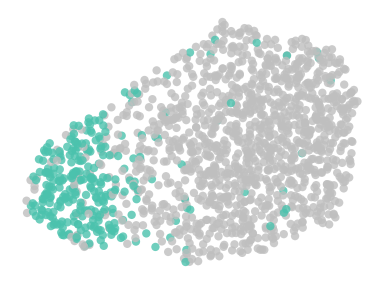

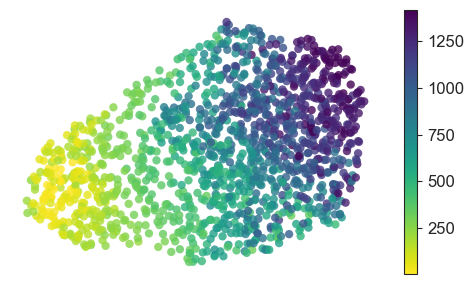

In [5]:
### SUZ12 dpt umaps

suz12 = adata_dict['SUZ12']
suz12_umap = pd.DataFrame(suz12.obsm['X_umap'], columns = ['u0', 'u1'])
suz12_umap['guide_identity'] = suz12.obs.guide_identity.values
suz12_umap['dpt_rank'] = suz12.obs.dpt_rank.values

with sns.axes_style("white"):
    
    plt.figure(figsize = (4,3))
    ax = sns.scatterplot(data = suz12_umap, x = 'u0', y = 'u1', edgecolor = 'none', alpha = 0.8, hue = 'guide_identity', legend = False, palette = sns.color_palette(['#bfbfbf','#4bc2ad']))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.tight_layout()
    plt.savefig("outs/figs_v1/fig2i_umap_perturbed.pdf")
    plt.show()

    plt.figure(figsize = (5,3))
    ax = sns.scatterplot(data = suz12_umap, x = 'u0', y = 'u1', edgecolor = 'none', alpha = 0.8, hue = 'dpt_rank', palette = 'viridis_r', legend = False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    
    norm = plt.Normalize(suz12_umap.dpt_rank.min(), suz12_umap.dpt_rank.max())
    sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax = ax)
    plt.tight_layout()
    plt.savefig("outs/figs_v1/fig2i_umap_dptrank.pdf")
    plt.show()

### 2j) Program features aligned with pseudotime, SOX5 enhancer accessibility and gene expression

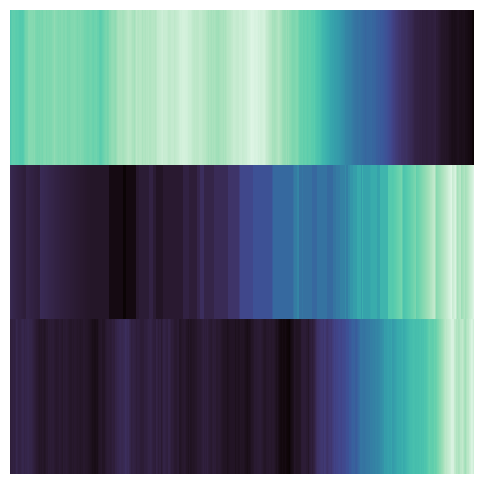

In [ ]:
df = plot_pt_heatmap('SUZ12', ['SUZ12', 'chr12:24563938-24564439', 'SOX5'], window = 500, fs = (5,5), savefig = 'outs/figs_v1/fig2j_sox5_pseudotime.png')

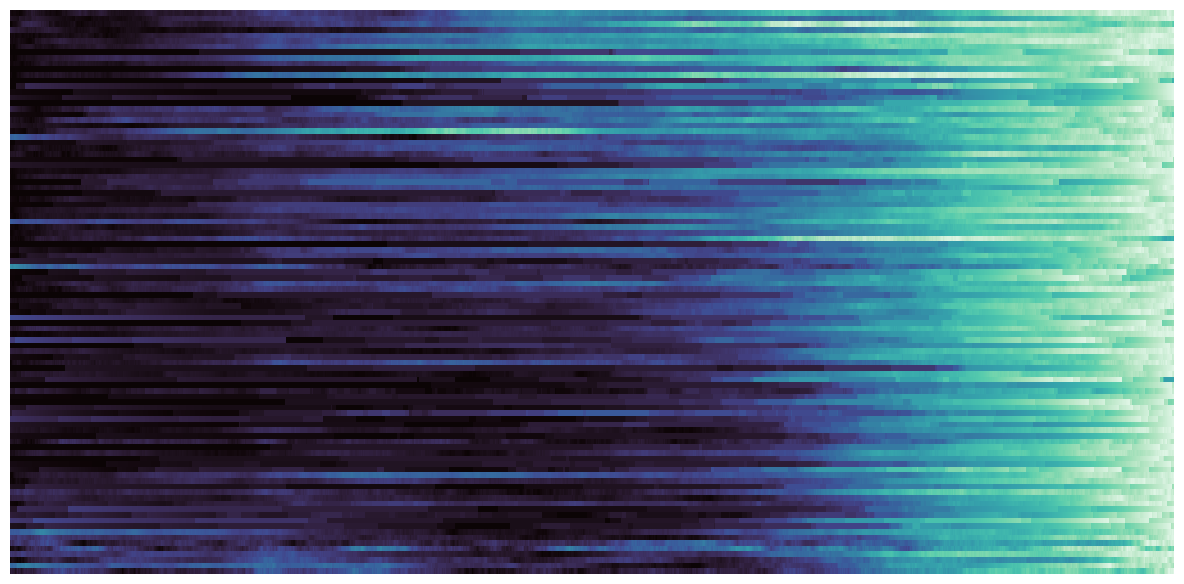

In [15]:
programs = pd.read_csv("/data/norman/eli/T7/202404_SIRLOIN_multiome/figs/supplementary_outs/TableS4_feature_weights.csv")
selected_features = programs.query("program_id == 4").sort_values("weight", ascending = False).head(100).feature
df = plot_pt_heatmap('SUZ12', selected_features, window = 500, return_plot_df = True, sort_features = 'corr', fs = (12,6), savefig = 'outs/figs_v1/fig2j_program_pseudotime.png')

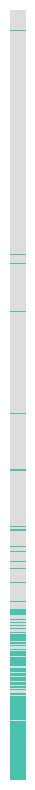

In [77]:
color_dict = {'NTC':'#dddddd', 'SUZ12':'#4bc2ad'}
ntc_map = dict(zip(color_dict.keys(), np.arange(len(color_dict.keys()))))

adata = adata_dict['SUZ12']
df_cells = df_normalized[['guide_identity']].join(adata.obs['dpt_pseudotime'], how = 'inner').sort_values("dpt_pseudotime")
df_cells_plot = df_cells.T[df_cells.T.columns[::-1]].T
df_cells_plot['guide_identity'] = df_cells_plot.guide_identity.map(ntc_map).astype(int)

cmap = ListedColormap([list(color_dict.values())[i] for i in sorted(df_cells_plot.guide_identity.tolist())])
plt.figure(figsize = (0.2,10))
sns.heatmap(df_cells_plot['guide_identity'].to_frame(), cmap = cmap, cbar = False, xticklabels = False, yticklabels=False)
plt.savefig("outs/fig2j_control_perturbed_bar.pdf")

### 2k) Autogluon modeling performance on program genes vs control genes

In [2]:
# read in Autogluon predictions

preds = pd.concat([pd.read_csv("/scratch/eli/AutogluonModels/scaled/test_preds_scaled_first129.csv"), pd.read_csv("/scratch/eli/AutogluonModels/scaled/test_preds.csv")], axis = 0)
preds['guide_target'] = preds.cluster.map(lambda s: s.split("_")[0])
preds['perturbed'] = preds.guide_target.map(lambda g: 'control' if g == 'NTC' else 'perturbed')
preds['complex'] = preds.guide_target.map(lambda g: 'NuA4' if g in ['ACTL6A', 'DMAP1', 'EP400'] else 'Poly' if g in ['EZH2', 'SUZ12', 'YY1'] else 'NTC' if g == 'NTC' else 'BAF')
preds['complex'] = pd.Categorical(preds.complex, categories=['NuA4', 'BAF', 'Poly', 'NTC'], ordered = True)
preds[['obs_expr', 'pred_expr']] = preds[['obs_expr', 'pred_expr']].map(lambda x: 100 * x)
performance = preds[['target_gene', 'test_spearman']].reset_index(drop=True).drop_duplicates()

In [3]:
# filter to protein coding genes and remove unannotated transcripts

gtf = pr.read_gtf('/fscratch/eli/genomes/refdata-gex-GRCh38-2020-A/genes/genes.gtf')[["Chromosome", "Feature", "Start", "End", "gene_id", "gene_type", "gene_name"]]
gtf = gtf[gtf.Feature == 'gene']
protein_coding = [g for g in gtf.df.query("gene_type == 'protein_coding'").gene_name.unique() if g.find('.') == -1]

/home/metznere/.conda/envs/scenv/lib/python3.11/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [4]:
# filter to genes within top 100 features in each program by weight

program_features = pd.read_csv("/data/norman/eli/T7/202404_SIRLOIN_multiome/figs/supplementary_outs/TableS4_feature_weights.csv")
top_genes_in_100 = [p for p in program_features.groupby('program_id').apply(lambda x: x.nlargest(100, 'weight')).query('feature_type == "gene"').feature.unique() if p in protein_coding]
print(len(top_genes_in_100))
prgm_performance = performance.query("target_gene.isin(@top_genes_in_100)")

457


/tmp/ipykernel_160129/3775313372.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [9]:
# get ctrl genes, updated to expression-matched controls, see Fig S8 for sampling of control genes to match expression distribution of program genes

expr_matched_ctrl = pd.read_csv("/data/norman/eli/T7/202404_SIRLOIN_multiome/figs/intermediate_files/autogluon_ctrl_genes_expr_matched.csv", index_col = 0)
print(prgm_performance.test_spearman.mean())
print(expr_matched_ctrl.test_spearman.mean())
print(ttest_ind(prgm_performance.test_spearman, expr_matched_ctrl.test_spearman).pvalue)

0.2395659001194126
0.13471144972102234
4.31803262864975e-11


2024-10-10 12:52:13 - INFO - maxp pruned
2024-10-10 12:52:13 - INFO - cmap pruned
2024-10-10 12:52:13 - INFO - post pruned
2024-10-10 12:52:13 - INFO - FFTM dropped
2024-10-10 12:52:13 - INFO - GPOS pruned
2024-10-10 12:52:13 - INFO - GSUB pruned
2024-10-10 12:52:13 - INFO - name pruned
2024-10-10 12:52:13 - INFO - glyf pruned
2024-10-10 12:52:13 - INFO - Added gid0 to subset
2024-10-10 12:52:13 - INFO - Added first four glyphs to subset
2024-10-10 12:52:13 - INFO - Closing glyph list over 'GSUB': 38 glyphs before
2024-10-10 12:52:13 - INFO - Glyph names: ['.notdef', '.null', 'C', 'N', 'P', 'S', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'uni0008', 'zero']
2024-10-10 12:52:13 - INFO - Glyph IDs:   [0, 1, 2, 3, 5, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 40, 51, 53, 56, 70, 71, 72, 73, 74, 75, 76, 77, 78, 81, 82, 83, 84, 85, 8

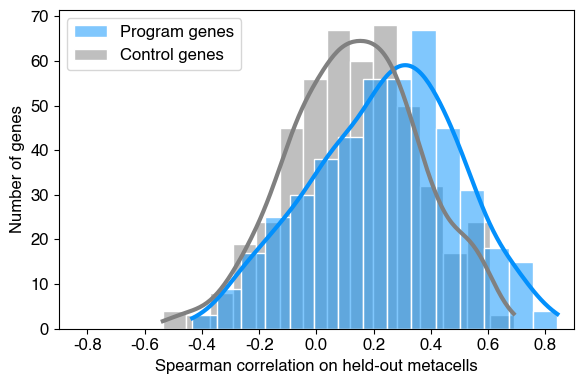

In [6]:
plt.figure(figsize = (6,4))
sns.histplot(data = prgm_performance, x = 'test_spearman', color = '#0390fc', alpha = 0.5, kde = True, bins = 15, edgecolor = 'white', line_kws={'linewidth': 3}, label = "Program genes", zorder = 2)
sns.histplot(data = expr_matched_ctrl, x = 'test_spearman', color = 'grey', alpha = 0.5, kde = True, bins = 15, edgecolor = 'white', line_kws={'linewidth': 3, 'color': 'darkgrey'}, label = 'Control genes')
plt.xlim(-0.9, 0.9)
plt.xlabel("Spearman correlation on held-out metacells")
plt.ylabel("Number of genes")
plt.legend()
plt.tight_layout()
plt.savefig("outs/fig2k_autogluon_performance_expr_matched.pdf")
plt.show()

In [60]:
dfs_selected = []
dfs_all = []
for file in os.scandir("/scratch/eli/AutogluonModels/scaled/"):
    if file.name.endswith("feature_importance.csv") and file.name.split("_")[0] in prgm_performance.target_gene.tolist():
        
        # we only count each tile once even if it overlaps two CREs; we keep the CRE with greater overlap
        df = pd.read_csv(file.path, index_col = 0)
        df['feature_id'] = df.apply(lambda df: df.iloc[0] if type(df.Chromosome) is float else f"{str(df.Chromosome)}:{str(int(df.Start))}-{str(int(df.End))}", axis = 1)
        df = df.sort_values(["importance", "Overlap"], ascending = False).set_index('feature_id')
        df_filtered = df.reset_index().drop_duplicates('feature_id', keep = 'first')
        
        dfs_all.append(df_filtered)
        dfs_selected.append(df_filtered.query("fdr < 0.1"))

df_selected = pd.concat(dfs_selected)
df_selected['importance_decile'] = pd.qcut(df_selected.importance, 10, duplicates='drop', labels = False)
df_all = pd.concat(dfs_all)

df_selected = df_selected.query("importance_decile == 9").reg.value_counts(normalize = True).to_frame("Top")
df_all = df_all.reg.value_counts(normalize = True).to_frame("All")

In [61]:
df_plot = pd.concat([df_selected, df_all], axis = 1).drop("-1", axis = 0).map(lambda x: x * 100).reset_index().melt(var_name = 'feature', value_name = 'percent', id_vars = 'reg')
df_plot['reg'] = pd.Categorical(df_plot.reg, categories = ['prom', 'K4m3', 'enhP', 'enhD', 'CTCF'], ordered = True)

In [64]:
p = (
    ggplot(df_plot)
    + geom_col(aes(x = 'feature', y = 'percent', fill = 'reg'))
    + theme_light()
    + theme(text=element_text(family="helvetica"))
    + theme(axis_text_x=element_text(size=12),  # Set X-axis label font size
            axis_text_y=element_text(size=12))
    + theme(figure_size=(4,3))
    + scale_fill_manual(values = ['#f7e642', '#c0df25', '#86c769', '#558f8c', '#444684'])
    + labs(x = "Feature subset", y = "Tiles (% of total across all genes)", fill = 'ENCODE \ncCRE')
    + ylim(0,50)
)
p.draw()
p.save("outs/fig2l_autogluon_feature_importance.pdf")

2024-09-23 18:37:01 - INFO - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
/home/metznere/.conda/envs/scenv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 4 x 3 in image.
/home/metznere/.conda/envs/scenv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: outs/fig2l_autogluon_feature_importance.pdf
2024-09-23 18:37:01 - INFO - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
2024-09-23 18:37:01 - INFO - maxp pruned
2024-09-23 18:37:01 - INFO - cmap pruned
2024-09-23 18:37:01 - INFO - post pruned
2024-09-23 18:37:01 - INFO - FFTM dropped
2024-09-23 18:37:01 - INFO - GPOS pruned
2024-09-23 18:37:01 - INFO - GSUB pruned
2024-09-23 18:37:01 - INFO - name pruned
2024-09-23 18:37:01 - INFO - glyf pruned
2024-09-23 18:37:01 - INFO - Added gid0 to subset
2024-09-23 18:37:01 - INFO - Added first four glyphs to subset
2024-09-23 18:37:01 - INFO - Closing glyph list over 'GSUB': 42 glyphs be

2024-09-24 11:53:51 - INFO - maxp pruned
2024-09-24 11:53:51 - INFO - cmap pruned
2024-09-24 11:53:51 - INFO - post pruned
2024-09-24 11:53:51 - INFO - FFTM dropped
2024-09-24 11:53:51 - INFO - GPOS pruned
2024-09-24 11:53:51 - INFO - GSUB pruned
2024-09-24 11:53:51 - INFO - name pruned
2024-09-24 11:53:51 - INFO - glyf pruned
2024-09-24 11:53:51 - INFO - Added gid0 to subset
2024-09-24 11:53:51 - INFO - Added first four glyphs to subset
2024-09-24 11:53:51 - INFO - Closing glyph list over 'GSUB': 49 glyphs before
2024-09-24 11:53:51 - INFO - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'F', 'G', 'H', 'N', 'O', 'P', 'R', 'S', 'T', 'W', 'X', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'percent', 'r', 's', 'seven', 'space', 't', 'three', 'two', 'u', 'uni0008', 'v', 'x', 'y', 'zero']
2024-09-24 11:53:51 - INFO - Glyph IDs:   [0, 1, 2, 3, 5, 10, 13, 14, 21, 22, 23, 24, 25, 26, 28, 29, 38, 39,

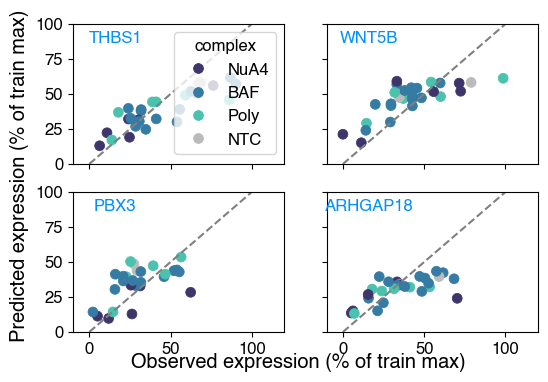

In [8]:
highlight_genes = ['THBS1', 'WNT5B', 'PBX3', 'ARHGAP18']
fig, ax = plt.subplots(2, 2, figsize = (6, 4), sharex = True, sharey = True)
for i, gene in enumerate(highlight_genes):
    df = preds.query(f"target_gene == '{gene}'")
    sns.scatterplot(data = df, x = 'obs_expr', y = 'pred_expr', hue = 'complex', ax = ax.flat[i], palette = sns.color_palette("mako", 3) + ['#bbbbbb'], legend = 'brief' if i == 0 else False, edgecolor = None, s = 50)
    plt.text(0.2, 0.9, gene, horizontalalignment='center', verticalalignment='center', transform=ax.flat[i].transAxes, color = '#0390fc', weight = 'bold')
    ax.flat[i].set_ylim(0,100)
    ax.flat[i].set_xlim(-10,120)
    ax.flat[i].axline((0, 0), slope=1, color = 'grey', linestyle = '--')
    ax.flat[i].set_xlabel("")
    ax.flat[i].set_ylabel("")
fig.supxlabel("Observed expression (% of train max)")
fig.supylabel("Predicted expression (% of train max)")
plt.savefig("outs/fig2m_autogluon_scatterplots.pdf")
plt.show()